In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as st
import pymc3 as pm
import arviz as az
import hyperspy.api as hs
import os

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


(0.0, 19.0)

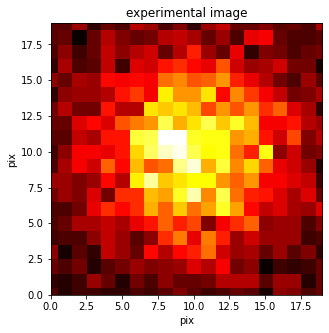

In [3]:
#Import images
cur_dir = os.getcwd()
if os.name == "nt":
    data_dir = os.path.dirname(cur_dir) + "\\data"    #notebookがあるフォルダと同列のdataフォルダ
    ds1 = hs.load(data_dir + '\\' + 'singl_atom.dm4')
if os.name == "posix":
    data_dir = os.path.dirname(cur_dir) + "//data"    #notebookがあるフォルダと同列のdataフォルダ
    ds1 = hs.load(data_dir + '//' + 'Bulk_Sr.dm4')    
s1 = hs.signals.Signal1D(ds1)
ydim, xdim, = s1.data.shape
img = np.flipud(s1.data)    #DMとpythonで上下がフリップするので反転して戻す

#Make plot
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(img, origin="lower", cmap="hot")
ax.set_title("experimental image")
ax.set_xlabel("pix")
ax.set_ylabel("pix")
ax.set_xlim(0, xdim-1)
ax.set_ylim(0, ydim-1)

In [4]:
#Make x-y grating
x_linspace = np.linspace(0, xdim-1, xdim)
y_linspace = np.linspace(0, ydim-1, ydim)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)
x_coords = x_grid.ravel()
y_coords = y_grid.ravel()
xy_coords = np.stack((x_coords, y_coords), axis=0).T

## Uniform background model

In [5]:
#Model(Uniform bachground)
back_model = "uniform"

with pm.Model() as model:
    xy = pm.Data('Coordinate', xy_coords)
    mu = pm.Uniform('Atom Position (μ)', lower=0, upper=xdim, shape=2)
    sigma = pm.Uniform('Noise (σ)', lower=0, upper=np.max(img.ravel()))
    bckgrd = pm.Uniform('Background Intensity', lower=0, upper=np.mean(img.ravel()))
    peak = pm.Uniform('Peak Intensity', lower=0, upper=np.max(img.ravel())*2)
    sd_dist = pm.Exponential.dist(1)
    packed_chol = pm.LKJCholeskyCov("Cholesky Matrix", n=2, eta=1, sd_dist=sd_dist, compute_corr=False)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.Deterministic('Covariance Matrix', chol.dot(chol.T))
    inv =  pm.math.matrix_inverse(cov)
    y = pm.Normal('Intensity', mu=(np.exp( -pm.math.extract_diag(pm.math.matrix_dot((xy-mu), inv, (xy-mu).T))/2.0)) * peak + bckgrd, sigma=sigma, observed=img.ravel())

In [6]:
#MCMC Sampling
with model:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=3,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 88 seconds.
INFO:pymc3:Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 88 seconds.


## Saddle background model

In [20]:
#Model(Saddle Background)
back_model = "uniform"
n = np.array([[1],[1]])
m = np.array([[1],[-1]])

with pm.Model() as model:
    xy = pm.Data('Coordinate', xy_coords)
    mu = pm.Uniform('Atom Position (μ)', lower=0, upper=xdim, shape=2)
    sigma = pm.Uniform('Noise (σ)', lower=0, upper=np.max(img.ravel()))
    bckgrd_flat = pm.Uniform('Background Intensity', lower=0, upper=np.mean(img.ravel())*2)
    a = pm.Uniform('Saddle1', lower=-100, upper=100)
    b = pm.Uniform('Saddle2', lower=-100, upper=100)
    p = xy.dot(n)-mu.dot(n)
    q = xy.dot(m)-mu.dot(m)
    bckgrd_saddle1 = a*(pm.math.extract_diag(p.dot(p.T)))
    bckgrd_saddle2 = b*(pm.math.extract_diag(q.dot(q.T)))
    peak = pm.Uniform('Peak Intensity', lower=0, upper=np.max(img.ravel())*2)
    sd_dist = pm.Exponential.dist(1)
    packed_chol = pm.LKJCholeskyCov("Cholesky Matrix", n=2, eta=1, sd_dist=sd_dist, compute_corr=False)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = pm.Deterministic("Covariance Matrix", chol.dot(chol.T))
    inv =  pm.math.matrix_inverse(cov)
    y = pm.Normal('Intensity', mu=(np.exp( -pm.math.extract_diag(pm.math.matrix_dot((xy-mu), inv, (xy-mu).T))/2.0)) * peak + bckgrd_flat + bckgrd_saddle1 + bckgrd_saddle2, sigma=sigma, observed=img.ravel())

In [21]:
#MCMC Sampling
back_model = "saddle"
with model:
    trace = pm.sample(
        draws=15000,
        tune=10000,
        chains=3,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (3 chains in 4 jobs)
NUTS: [Cholesky Matrix, Peak Intensity, Saddle2, Saddle1, Background Intensity, Noise (σ), Atom Position (μ)]
INFO:pymc3:NUTS: [Cholesky Matrix, Peak Intensity, Saddle2, Saddle1, Background Intensity, Noise (σ), Atom Position (μ)]


Sampling 3 chains for 7_000 tune and 14_000 draw iterations (21_000 + 42_000 draws total) took 2117 seconds.
INFO:pymc3:Sampling 3 chains for 7_000 tune and 14_000 draw iterations (21_000 + 42_000 draws total) took 2117 seconds.
The acceptance probability does not match the target. It is 0.9395289832108041, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8985390738771936, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926416723919176, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


## Summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Atom Position (μ)[0],9.846,0.089,9.690,10.028,0.002,0.001,3258.0,1923.0,1.0
Atom Position (μ)[1],9.975,0.089,9.804,10.138,0.002,0.001,2693.0,2010.0,1.0
Noise (σ),4.475,0.163,4.186,4.788,0.003,0.002,2747.0,2274.0,1.0
Background Intensity,6.616,0.626,5.442,7.733,0.016,0.012,1484.0,1508.0,1.0
Peak Intensity,39.579,0.884,37.960,41.245,0.016,0.011,3169.0,2381.0,1.0
Cholesky Matrix[0],4.349,0.146,4.062,4.602,0.004,0.003,1693.0,1992.0,1.0
Cholesky Matrix[1],-0.022,0.130,-0.244,0.230,0.002,0.002,2856.0,2346.0,1.0
Cholesky Matrix[2],4.386,0.140,4.142,4.666,0.003,0.002,1652.0,1781.0,1.0
"Covariance Matrix[0, 0]",18.938,1.270,16.398,21.061,0.031,0.022,1693.0,1992.0,1.0
"Covariance Matrix[0, 1]",-0.095,0.566,-1.058,1.014,0.011,0.010,2862.0,2347.0,1.0


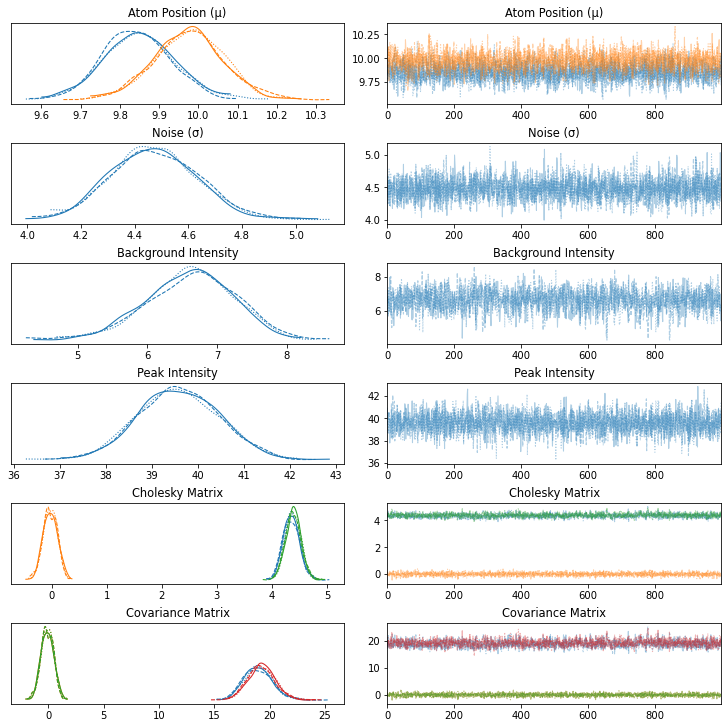

In [7]:
#Display summary
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, figsize=(10,10))
az.summary(trace)

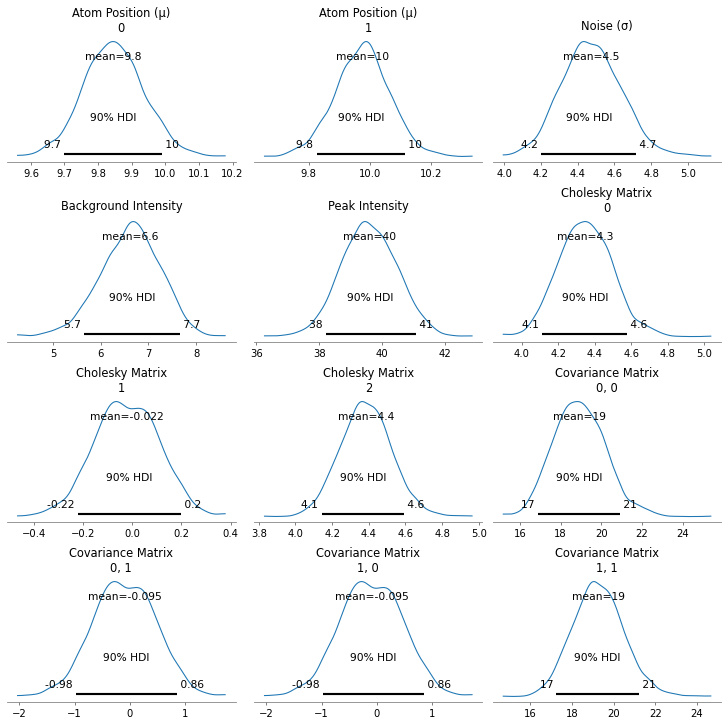

In [8]:
#Display credible interval
az.plot_posterior(trace, hdi_prob=0.9, backend_kwargs={"constrained_layout":True}, figsize=(10,10), textsize=10);

## Plot predicted images with deviation

In [22]:
with model:
    pred_var = pm.sample_posterior_predictive(trace, samples=10, var_names=['Atom Position (μ)'])

In [23]:
pred_var

{'Atom Position (μ)': array([[ 9.87729039,  9.91243323],
        [ 9.82800927,  9.95705453],
        [ 9.87590277, 10.11566323],
        [ 9.87027186, 10.11379971],
        [ 9.93086831,  9.8787718 ],
        [ 9.81248646,  9.7616597 ],
        [ 9.98069604,  9.94083872],
        [ 9.89465286, 10.07761757],
        [ 9.91059062, 10.06046531],
        [ 9.82538705, 10.0773205 ]])}

In [34]:
#Sample for verification
num_plot = 10

with model:
    pred_intensity = pm.sample_posterior_predictive(trace, samples=num_plot)
    if back_model == "uniform":
        pred_var = pm.sample_posterior_predictive(trace, samples=num_plot, var_names=['Atom Position (μ)', 'Noise (σ)', 'Background Intensity', 'Peak Intensity', 'Covariance Matrix'])
    if back_model == "saddle":
        pred_var = pm.sample_posterior_predictive(trace, samples=num_plot, var_names=['Atom Position (μ)', 'Noise (σ)', 'Background Intensity', 'Peak Intensity', 'Covariance Matrix', 'Saddle1', 'Saddle2'])
        
intensity_pred_samples = pred_intensity['Intensity']
noise_less_intensity_pred_samples = np.zeros((num_plot, xdim*ydim))
for i in range(num_plot):
    inv = np.linalg.inv(pred_var['Covariance Matrix'][i])
    if back_model == "uniform":
        noise_less_intensity_pred_samples[i] = np.exp( -np.diag((xy_coords-pred_var['Atom Position (μ)'][i]) @ inv @ ((xy_coords-pred_var['Atom Position (μ)'][i]).T))/2.0) * pred_var['Peak Intensity'][i] + pred_var['Background Intensity'][i]
    if back_model == "saddle":
        noise_less_intensity_pred_samples[i] = np.exp( -np.diag((xy_coords-pred_var['Atom Position (μ)'][i]) @ inv @ ((xy_coords-pred_var['Atom Position (μ)'][i]).T))/2.0) * pred_var['Peak Intensity'][i] + pred_var['Background Intensity'][i] + pred_var['Saddle1'][i] + pred_var['Saddle2'][i]



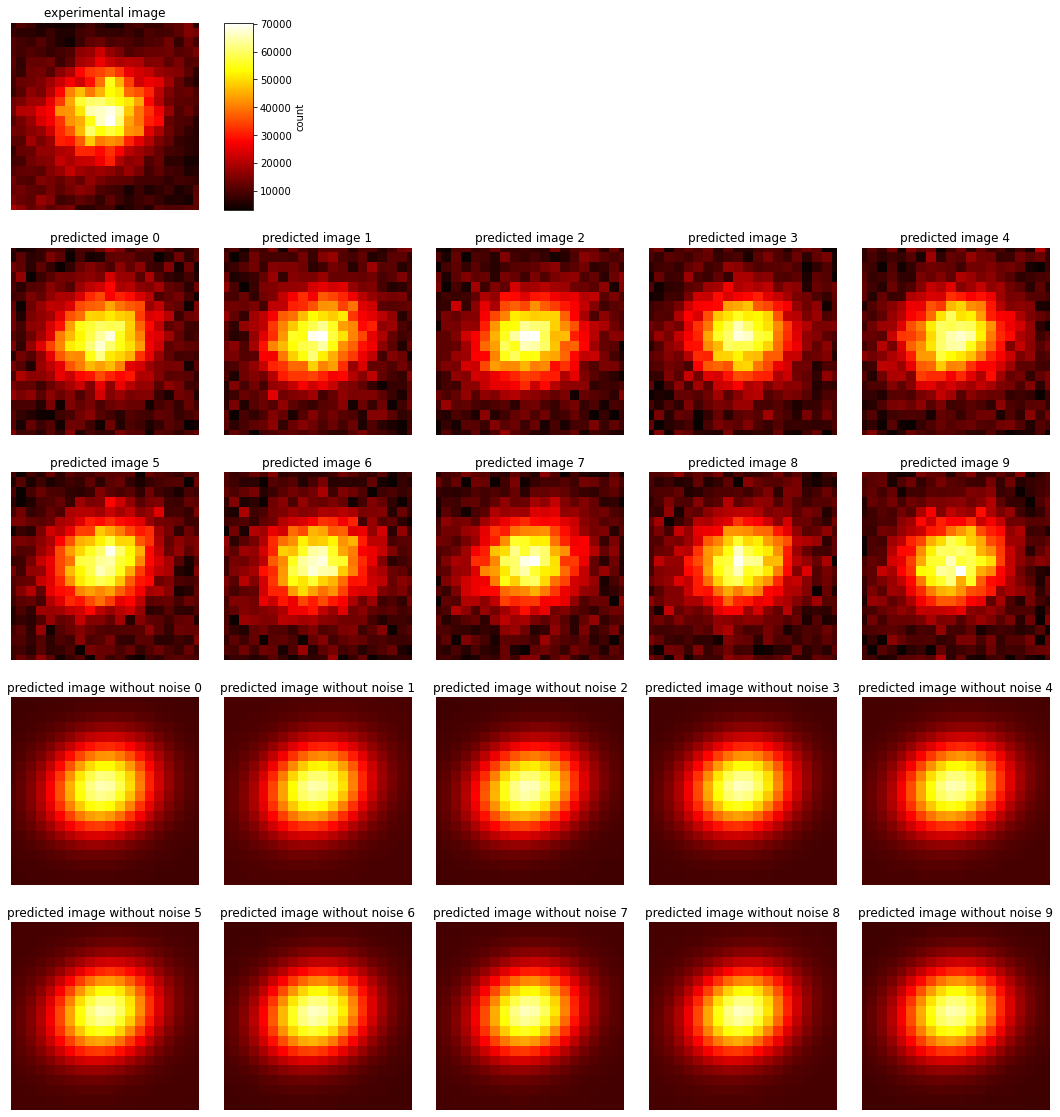

In [35]:
#Make plot
col = int((num_plot-0.1)//5 + 2)
row = 5
fig, ax = plt.subplots(col*2-1, row, figsize=(20,20))
ax[0][0].imshow(img, origin="lower", cmap="hot", vmin=np.min(img), vmax=np.max(img))
ax[0][0].set_title("experimental image")
ax[0][0].set_xlim(0, xdim-1)
ax[0][0].set_ylim(0, ydim-1)
ax[0][0].axis('off')

ax[0][0].imshow(img, origin="lower", cmap="hot", vmin=np.min(img), vmax=np.max(img))
ax[0][0].set_title("experimental image")
ax[0][0].set_xlim(0, xdim-1)
ax[0][0].set_ylim(0, ydim-1)
ax[0][0].axis('off')

for i in range(row-1):
    ax[0][i+1].axis('off')

k = 0
for i in range(col-1):
    for j in range(row):
        ax[i+1][j].imshow(np.reshape(intensity_pred_samples[k], (ydim,xdim)), origin="lower", cmap="hot", vmin=np.min(img), vmax=np.max(img))
        ax[i+1][j].set_title("predicted image " + str(k))
        ax[i+1][j].set_xlim(0, xdim-1)
        ax[i+1][j].set_ylim(0, ydim-1)
        ax[i+1][j].axis('off')
        k += 1
        if k >= num_plot:
            break
    if k >= num_plot:
        break
        
k = 0
for m in range(col-1):
    for n in range(row):
        ax[m+i+2][n].imshow(np.reshape(noise_less_intensity_pred_samples[k], (ydim,xdim)), origin="lower", cmap="hot", vmin=np.min(img), vmax=np.max(img))
        ax[m+i+2][n].set_title("predicted image without noise " + str(k))
        ax[m+i+2][n].set_xlim(0, xdim-1)
        ax[m+i+2][n].set_ylim(0, ydim-1)
        ax[m+i+2][n].axis('off')
        k += 1
        if k >= num_plot:
            break
    if k >= num_plot:
        break

im = ax[0,0].pcolormesh(x_grid, y_grid, img, cmap='hot')
axpos = ax[0,0].get_position()
cbar_ax = fig.add_axes([0.275, axpos.y0, 0.02, axpos.height])
cbar = fig.colorbar(im,cax=cbar_ax)
cbar.set_label("count")
plt.subplots_adjust(right=0.85)
plt.subplots_adjust(wspace=0.1)

## Plot images with arbitrary variables

In [105]:
xdim = 20
ydim = 20
x_linspace = np.linspace(0, xdim-1, xdim)
y_linspace = np.linspace(0, ydim-1, ydim)
x_grid, y_grid = np.meshgrid(x_linspace, y_linspace)

x_coords = x_grid.ravel()
y_coords = y_grid.ravel()
xy_coords = np.stack((x_coords, y_coords), axis=0).T

n = np.array([[1],[1]])
m = np.array([[1],[-1]])

sigma = 1509.491
bckgrd = 5137.171
peak = 4696.642
mu = np.array([9.666,9.512])
cov = np.array([[18.285,-0.471],[-0.471,18.867]])
a = 0
b = 0
#det = np.linalg.det(cov)
inv =  np.linalg.inv(cov)
p = xy_coords.dot(i)-mu.dot(i)
q = xy_coords.dot(m)-mu.dot(m)
bckgrd_saddle1 = a*(np.diag(p.dot(p.T)))
bckgrd_saddle2 = b*(np.diag(q.dot(q.T)))
#intensity = np.exp( -np.diag((xy_coords-mu) @ inv @ (xy_coords-mu).T)/2.0) / ((2 * np.pi) * np.sqrt(det)) + bckgrd
intensity = np.exp( -np.diag((xy_coords-mu) @ inv @ (xy_coords-mu).T)/2.0) * peak + bckgrd + bckgrd_saddle1 + bckgrd_saddle2 + np.random.normal(0, sigma, xdim*ydim)
#intensity
#bckgrd_saddle1

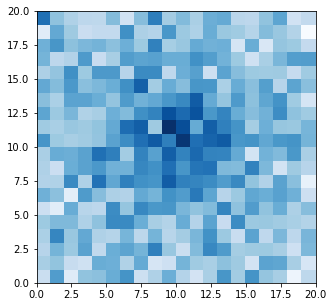

In [106]:
output = intensity.reshape((xdim,ydim))

#fig, ax = plt.figure(figsize=(20,20))
fig, ax = plt.subplots(figsize=(5,5))
heatmap = ax.pcolor(output, cmap=plt.cm.Blues)
plt.show()

In [107]:
np.savetxt(
    "sample.csv",
    output,
    delimiter=","
)